## Recommending instagram accounts by analysing their description

Some notes I've discovered during my search for Instagram user distance.

Visualisations based on https://de.dariah.eu/tatom/working_with_text.html#visualizing-distances.


In [1]:
import pandas as pd
import psycopg2
import psycopg2.extras

conn = psycopg2.connect("dbname=instagram")
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

cur.execute("SELECT raw_text, username FROM media")
data = cur.fetchall()
media = list(map(lambda i: i[0], data))
usernames = list(map(lambda i: i[1], data))

### Generate document-term matrix

In [2]:
import numpy as np
import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(input='content', strip_accents='ascii', stop_words='english', min_df=10)

dtm = vectorizer.fit_transform(media).toarray()

vocab = np.array(vectorizer.get_feature_names())

#### How many times user has used some word

In [3]:
me_idx = usernames.index('josef.rousek')
dtm[me_idx, vocab == 'prague']

# is the same as
# prague_idx = list(vocab).index('prague')
# dtm[me_idx, prague_idx]

array([3], dtype=int64)

### user similarity

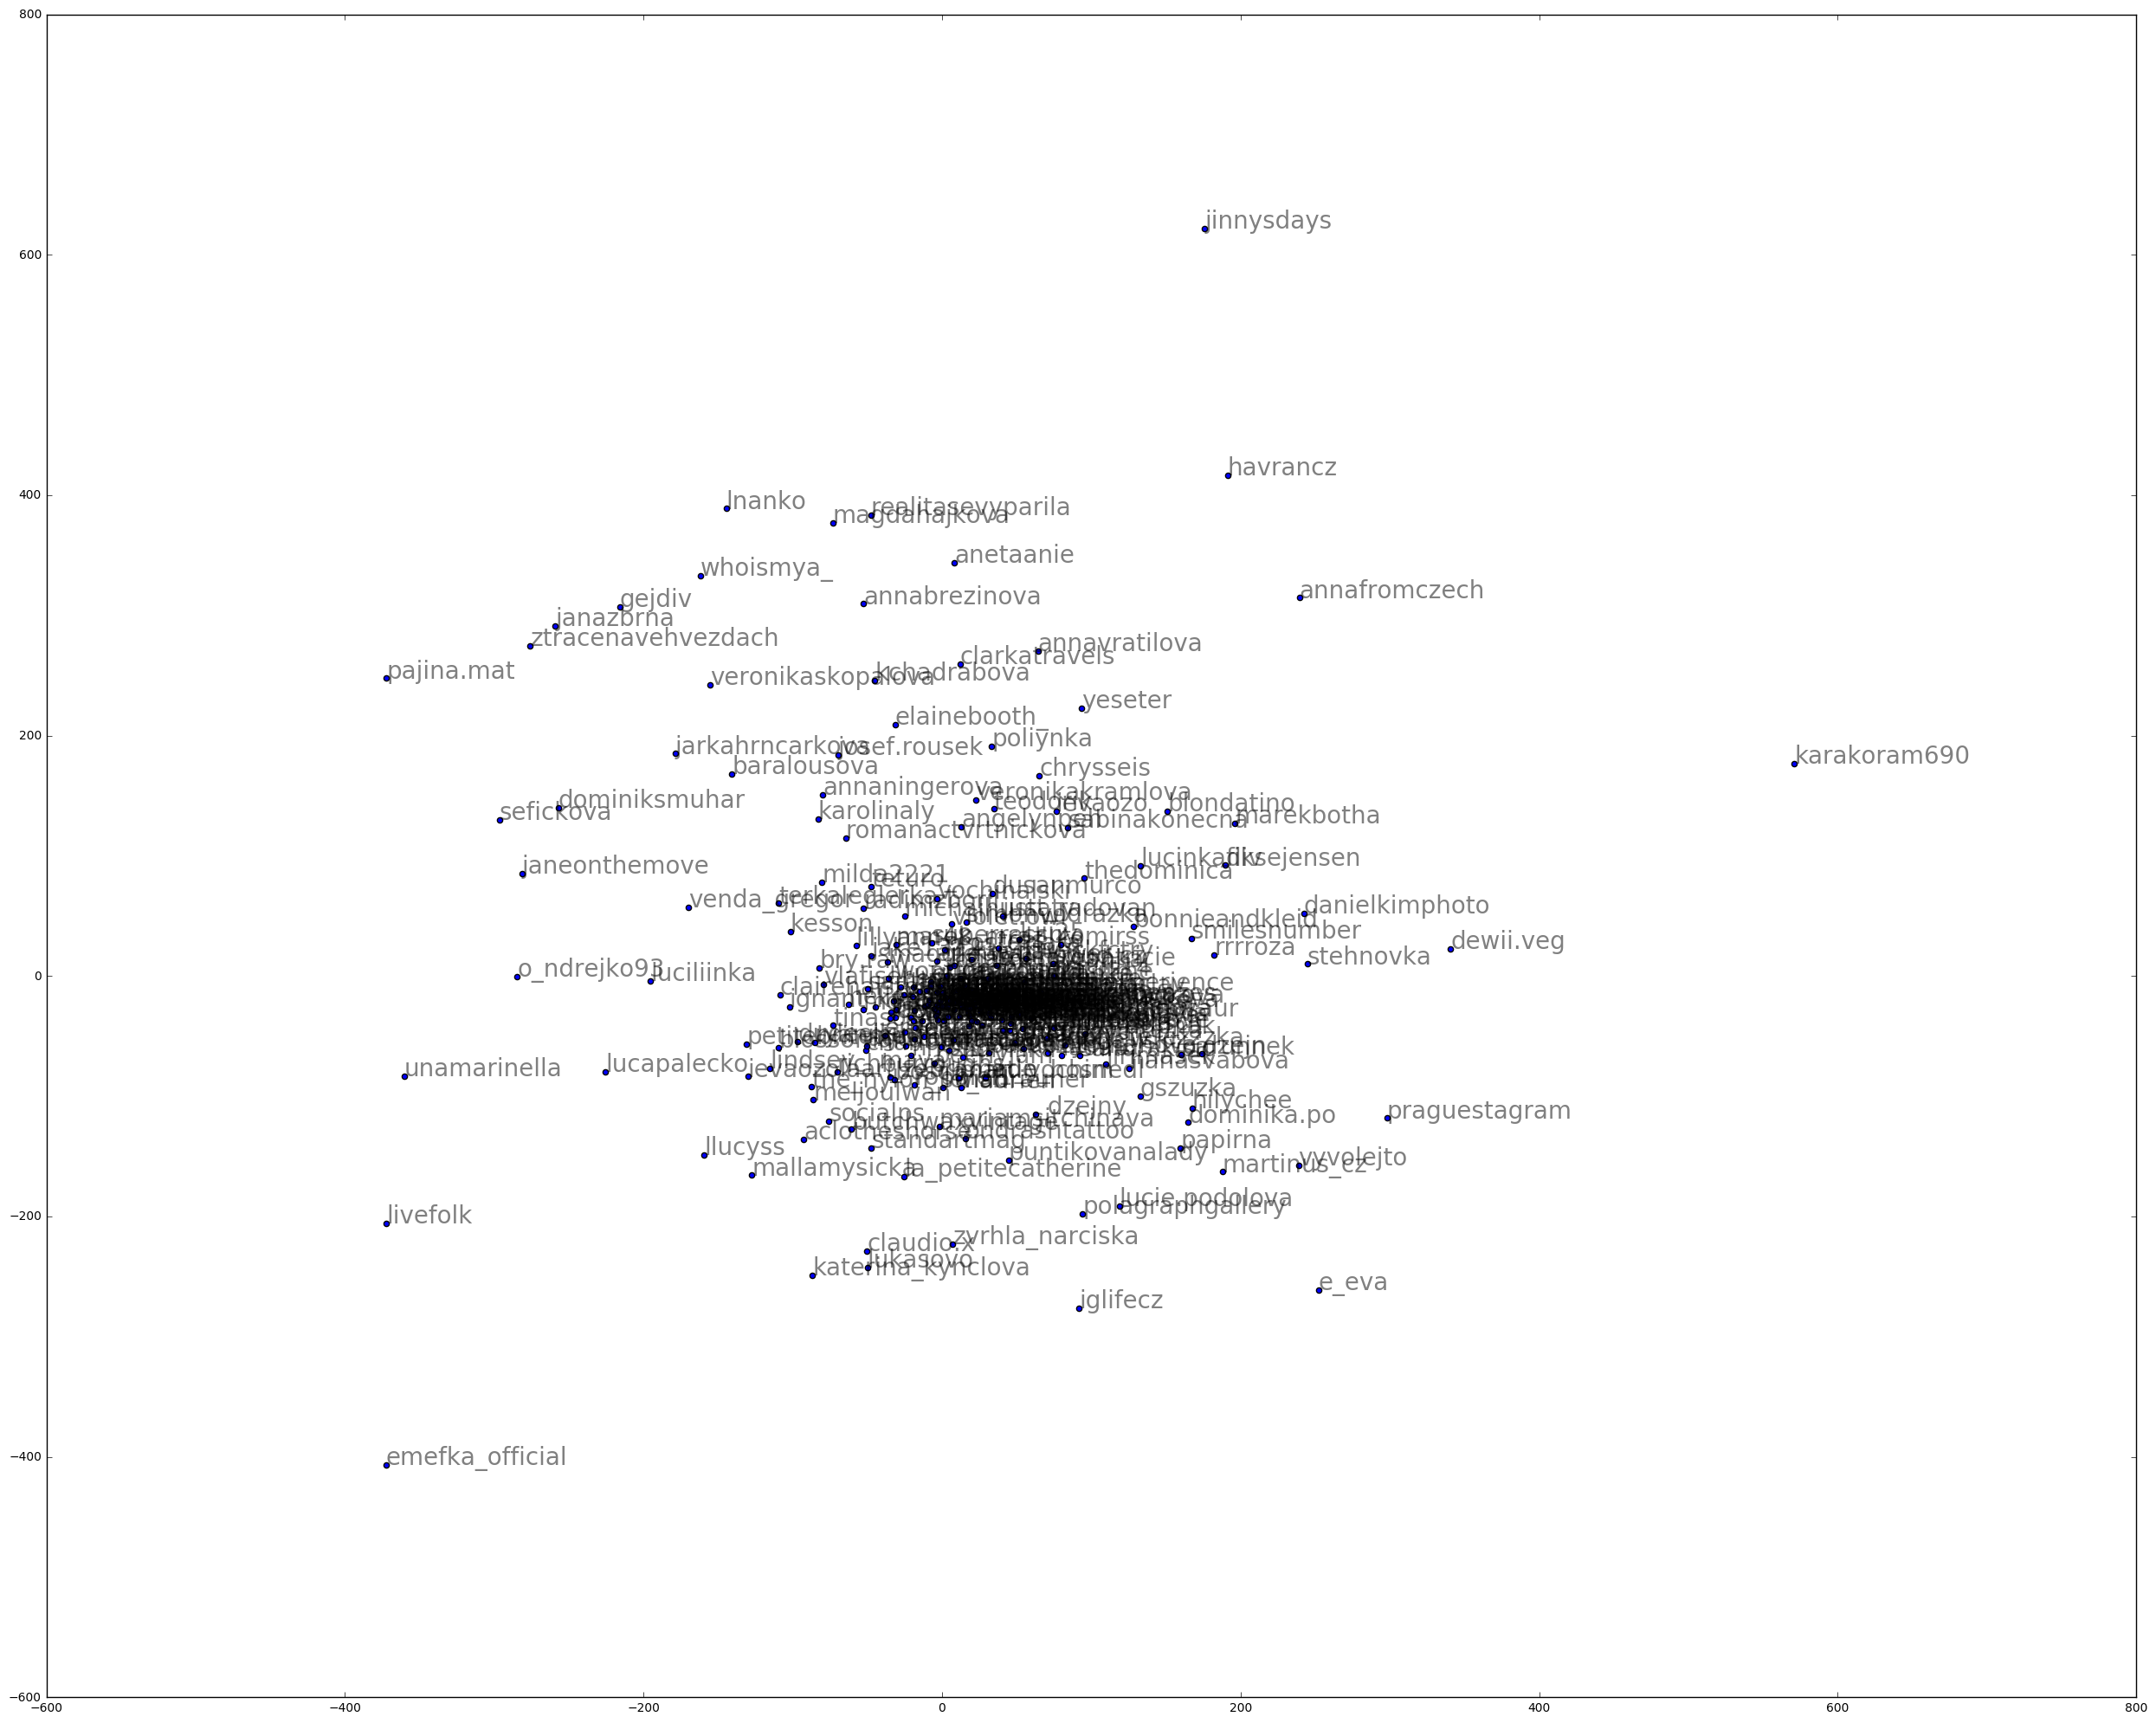

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

mds = MDS(n_components=2, dissimilarity="euclidean", random_state=1)
pos = mds.fit_transform(dtm)  # shape (n_components, n_samples)

plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

plt.tight_layout() 

### user distance

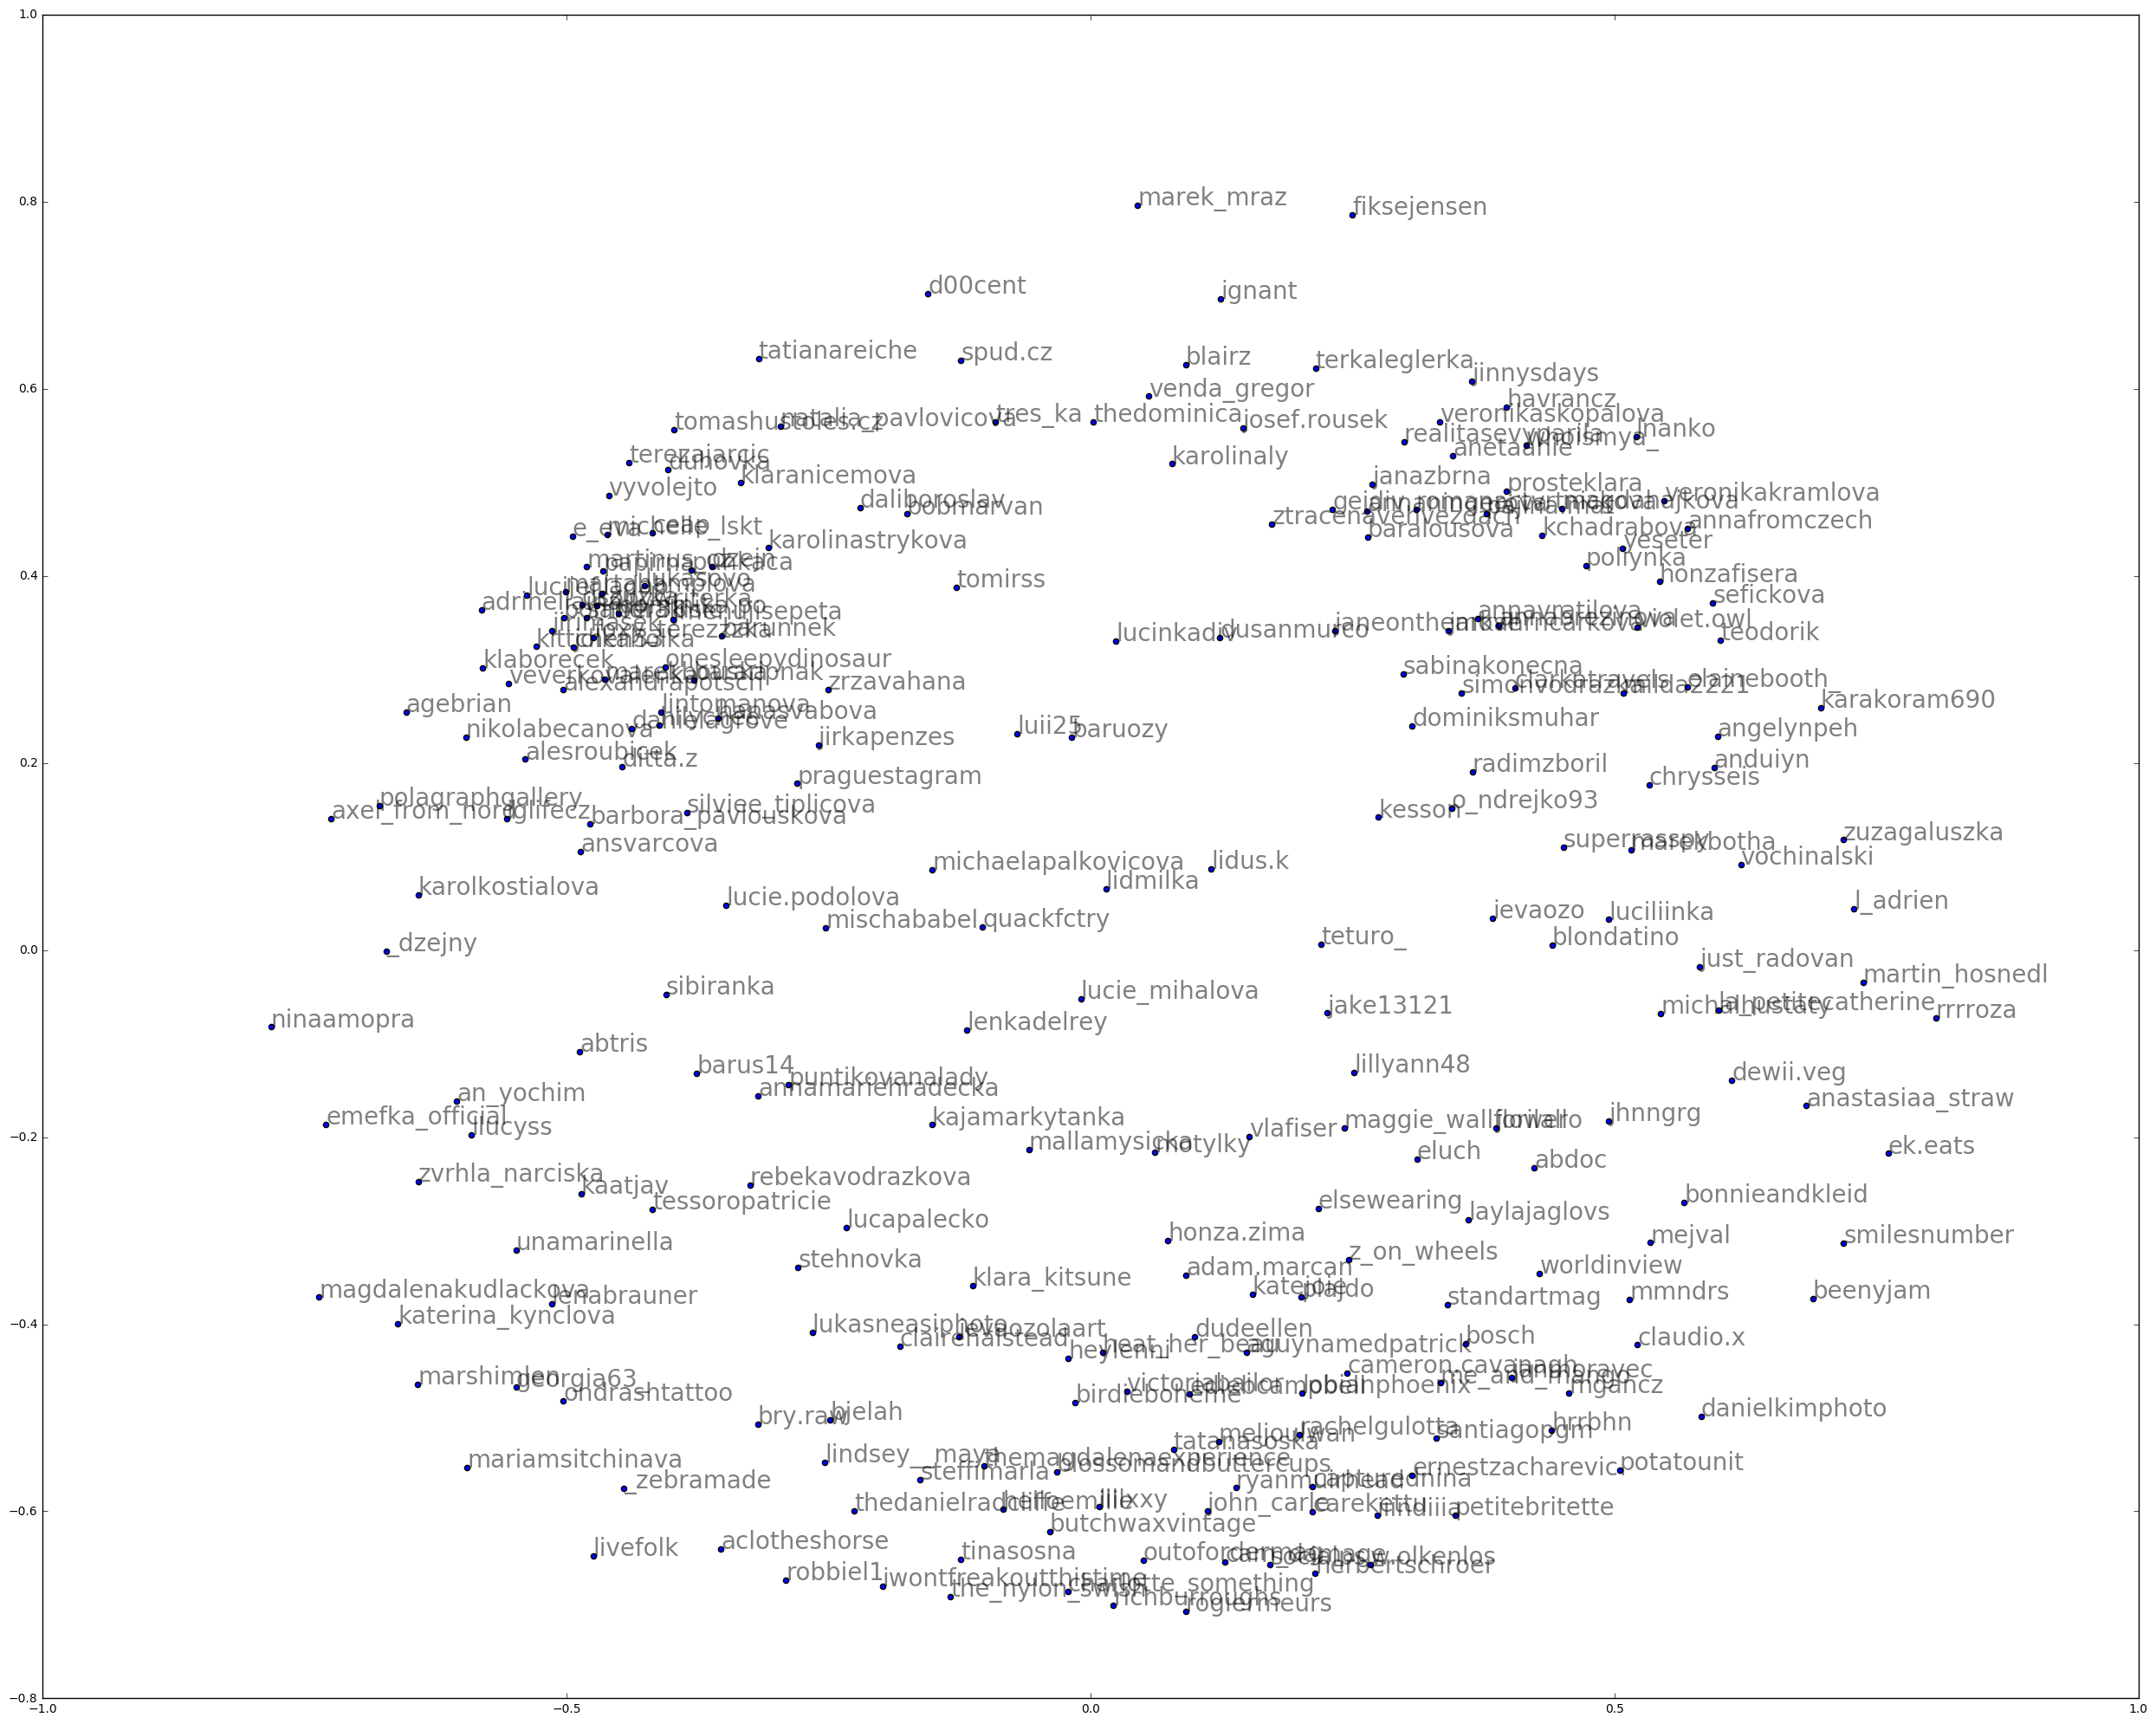

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

# we need distance, not similarity
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)


plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

plt.tight_layout()


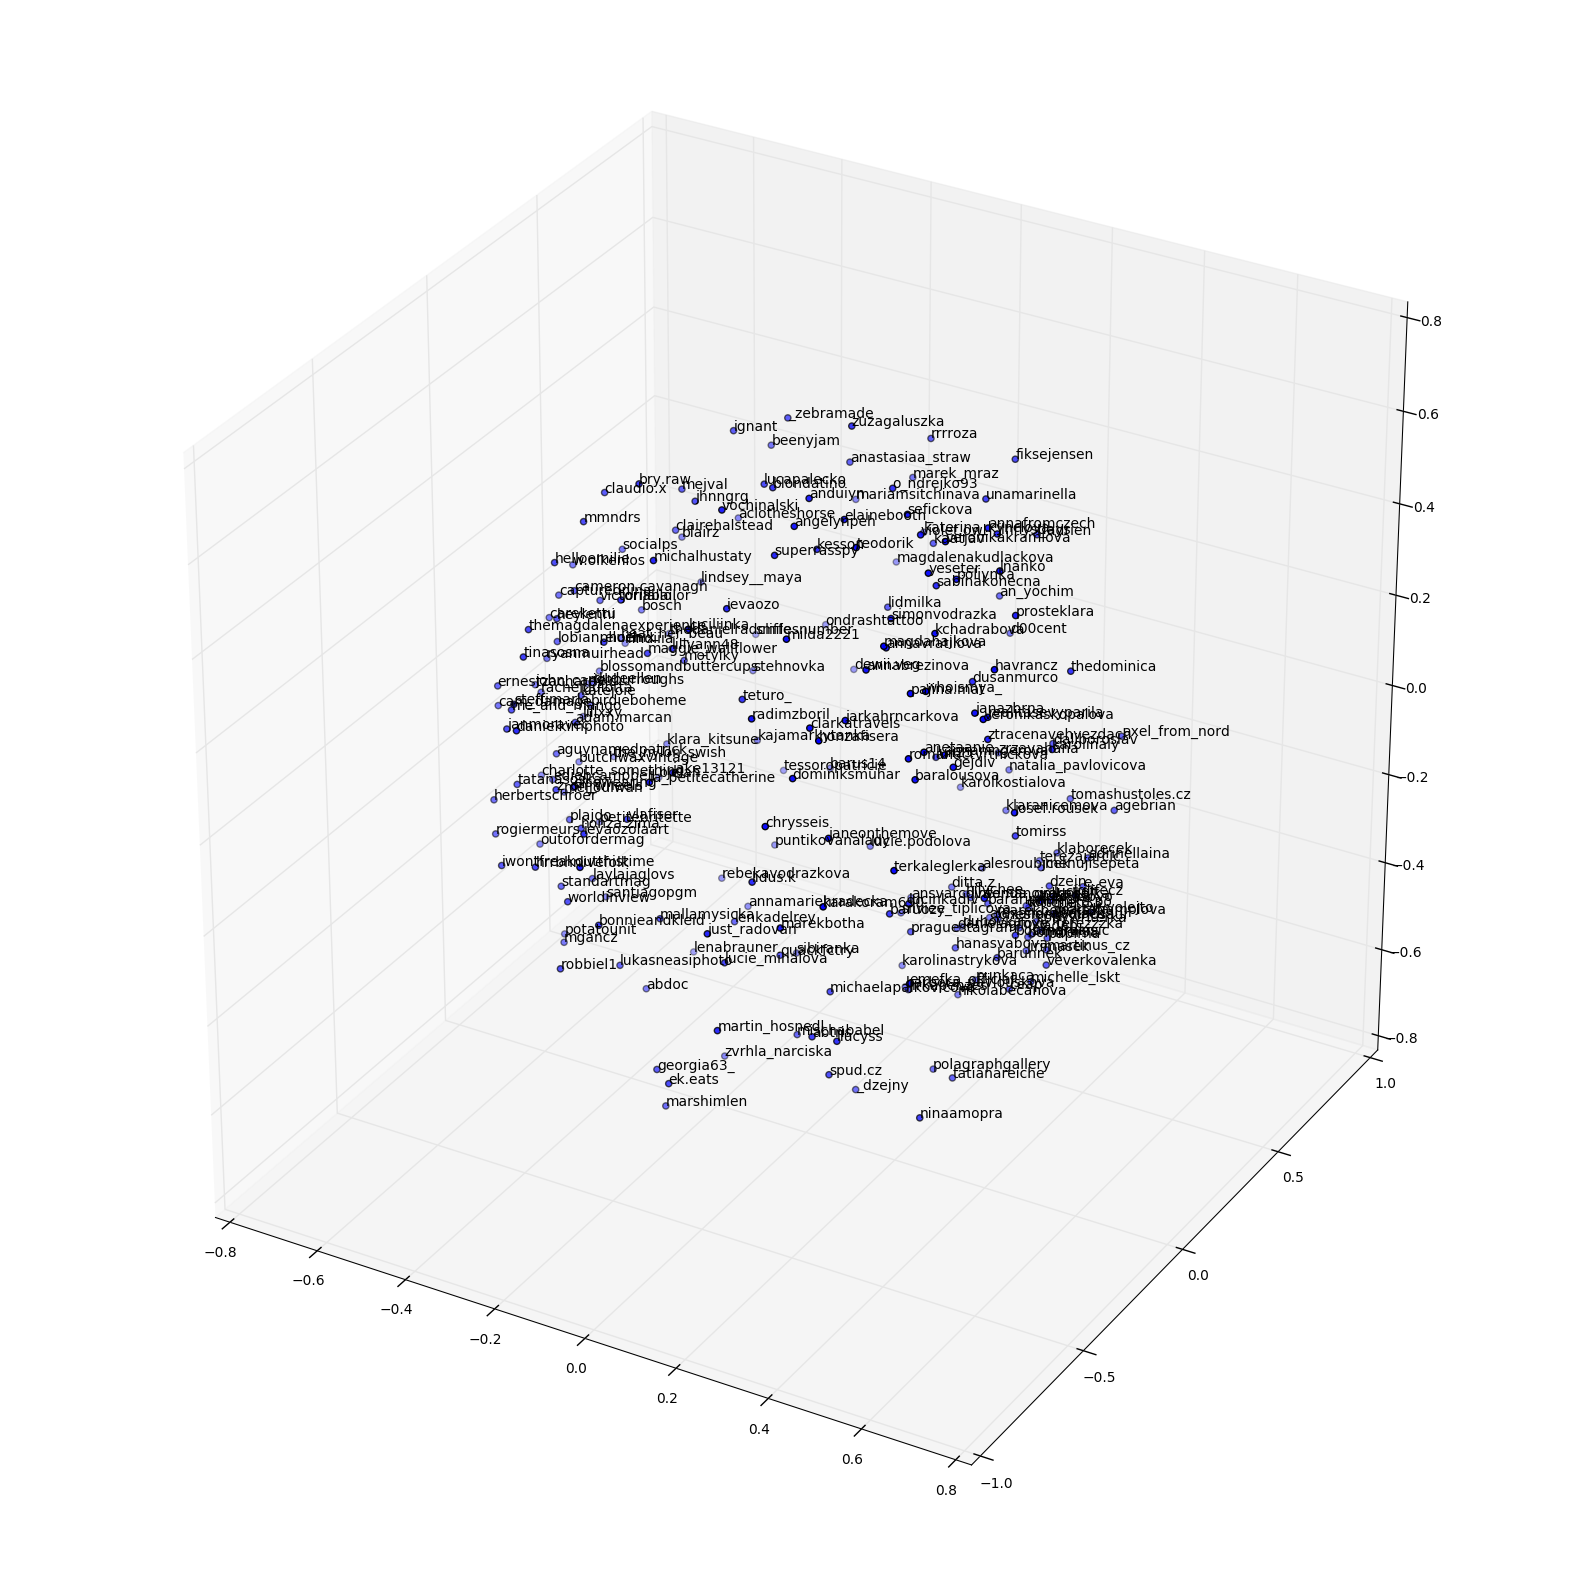

In [6]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))  # use a bigger canvas than usual

ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], usernames):
    ax.text(x, y, z, s)

plt.show()

### Distances between users



In [7]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(dtm)

np.round(dist, 1)

array([[   0. ,  147.2,  137. , ...,   70.6,   36.3,  551.2],
       [ 147.2,    0. ,  150.8, ...,  162.9,  145.5,  569.3],
       [ 137. ,  150.8,    0. , ...,  153.8,  134.5,  566.5],
       ..., 
       [  70.6,  162.9,  153.8, ...,    0. ,   71.5,  554.2],
       [  36.3,  145.5,  134.5, ...,   71.5,    0. ,  550.4],
       [ 551.2,  569.3,  566.5, ...,  554.2,  550.4,    0. ]])

In [8]:
# I don't want to see media from this account
dist[usernames.index('josef.rousek'), usernames.index('emefka_official')]

551.55507431262026

In [9]:
# This one is fine
dist[usernames.index('josef.rousek'), usernames.index('iglifecz')]

273.70239312070328

In [10]:
# This one is fine
dist[usernames.index('josef.rousek'), usernames.index('motylky')]

236.18001608942276

In [11]:
# Calculate threshold
np.mean(dist) * 2

407.99739395596782

In [12]:
distances = euclidean_distances(dtm)
users_with_distance = [(user, distances[usernames.index('josef.rousek'), usernames.index(user)]) for user in usernames]
users_with_distance.sort(key=lambda user: user[1])

# pd.set_option('display.max_rows', 200)
pd.DataFrame(users_with_distance)

,0,1
0,josef.rousek,0.000000
1,romanactvrtnickova,168.439900
2,annaningerova,184.382754
3,baralousova,193.631093
4,tres_ka,195.573516
5,radimzboril,206.004854
6,terkaleglerka,210.283142
7,tomirss,215.227786
8,bobmarvan,216.085631
9,milda2221,218.348346
